In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pwd

'/content'

In [3]:
cd /content/drive/MyDrive/Predictive Maintenance For Industrial Machinery/NASA Turbofan 2/NASA Turbofan 2

/content/drive/MyDrive/Predictive Maintenance For Industrial Machinery/NASA Turbofan 2/NASA Turbofan 2


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na.*")

<h3>Data Loading</h3>

In [5]:
import glob as gl
import pandas as pd
import pathlib as pth


def load_file(path: str, load_all: bool = False, filter: str = None, sep: str = None, header: int = 0) -> pd.DataFrame:
    if pth.Path(path).is_file():
        if path.endswith(".csv"):
            dfs = pd.read_csv(path, header=header)
        elif path.endswith(".txt"):
            dfs = pd.read_csv(path, sep=sep, header=header)
        elif path.endswith(".xlsx"):
            dfs = pd.read_excel(path, header=header)
    elif pth.Path(path).is_dir() and load_all:
        df_list = []
        files = gl.glob(f"{path}/*")
        if filter:
            files = [i for i in files if filter in i]
        print("files to be loaded:", files)
        for file in files:
            if file.endswith(".csv"):
                df = pd.read_csv(file, low_memory=False, header=header)
                df_list.append(df)
            elif file.endswith(".txt"):
                df = pd.read_csv(file, sep=sep, header=header)
                df_list.append(df)
            elif file.endswith(".xlsx"):
                df = pd.read_excel(file, header=header)
                df_list.append(df)
        dfs = pd.concat(df_list)
        dfs.reset_index(drop=True, inplace=True)
    elif pth.Path(path).is_dir() and not load_all:
        raise ValueError("load_all should be True")
    else:
        raise ValueError("error")

    return dfs

In [6]:
df_columns = {
    0: "engine",
    1: "cycle_time",
    2: "operational_set_1",
    3: "operational_set_2",
    4: "operational_set_3",
    5: "T2",
    6: "T24",
    7: "T30",
    8: "T50",
    9: "P2",
    10: "P15",
    11: "P30",
    12: "Nf",
    13: "Nc",
    14: "epr",
    15: "Ps30",
    16: "phi",
    17: "NRf",
    18: "NRc",
    19: "BPR",
    20: "farB",
    21: "htBleed",
    22: "Nf_dmd",
    23: "PCNfR_dmd",
    24: "W31",
    25: "W32",
}

RUL_columns = {
    0: "RUL"
}

In [7]:
train_df = load_file(path="CMaps/train_FD001.txt", load_all=False, sep="\s+", header=None)
test_df = load_file(path="CMaps/test_FD001.txt", load_all=False, sep="\s+", header=None)
RUL_df = load_file(path="CMaps/RUL_FD001.txt", load_all=False, sep="\s+", header=None)

In [8]:
train_df = train_df.rename(columns=df_columns)
test_df = test_df.rename(columns=df_columns)
RUL_df = RUL_df.rename(columns=RUL_columns)
RUL_df["engine"] = RUL_df.index + 1

In [9]:
print(train_df.head())
print(test_df.head())
print(RUL_df.head())

   engine  cycle_time  operational_set_1  operational_set_2  \
0       1           1            -0.0007            -0.0004   
1       1           2             0.0019            -0.0003   
2       1           3            -0.0043             0.0003   
3       1           4             0.0007             0.0000   
4       1           5            -0.0019            -0.0002   

   operational_set_3      T2     T24      T30      T50     P2  ...     phi  \
0              100.0  518.67  641.82  1589.70  1400.60  14.62  ...  521.66   
1              100.0  518.67  642.15  1591.82  1403.14  14.62  ...  522.28   
2              100.0  518.67  642.35  1587.99  1404.20  14.62  ...  522.42   
3              100.0  518.67  642.35  1582.79  1401.87  14.62  ...  522.86   
4              100.0  518.67  642.37  1582.85  1406.22  14.62  ...  522.19   

       NRf      NRc     BPR  farB  htBleed  Nf_dmd  PCNfR_dmd    W31      W32  
0  2388.02  8138.62  8.4195  0.03      392    2388      100.0  39.06  23

<h3>Feature Selection and Engineering</h3>

In [14]:
max_time_cycles = train_df.groupby("engine")["cycle_time"].max()
# To check result
# for idx, row in max_time_cycles.reset_index().iterrows():
#     print("Engine:", row["engine"], "Failure_time:", row["cycle_time"])
# merge into maximum cycle time into train df
merged = train_df.merge(max_time_cycles.to_frame(name="max_time_cycle"), left_on="engine", right_index=True)
# calculate RUL = maximum cycle time - each cycle time
merged["RUL"] = merged["max_time_cycle"] - merged["cycle_time"]
# drop maximum cycle time (not used)
merged = merged.drop("max_time_cycle", axis=1)
# update train df with RUL
train_df = merged

In [15]:
train_df.head()

,engine,cycle_time,operational_set_1,operational_set_2,operational_set_3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# Display basic info
print("📋 Dataset Shape:", train_df.shape)
print("\n🧠 Data Types and Missing Values:")
print(train_df.info())

# Show basic statistics
print("\n📊 Statistical Summary:")
print(train_df.describe())

# Preview data
print("\n🔍 First few rows:")
print(train_df.head())


📋 Dataset Shape: (20631, 27)

🧠 Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   engine             20631 non-null  int64  
 1   cycle_time         20631 non-null  int64  
 2   operational_set_1  20631 non-null  float64
 3   operational_set_2  20631 non-null  float64
 4   operational_set_3  20631 non-null  float64
 5   T2                 20631 non-null  float64
 6   T24                20631 non-null  float64
 7   T30                20631 non-null  float64
 8   T50                20631 non-null  float64
 9   P2                 20631 non-null  float64
 10  P15                20631 non-null  float64
 11  P30                20631 non-null  float64
 12  Nf                 20631 non-null  float64
 13  Nc                 20631 non-null  float64
 14  epr                20631 non-null  float64
 15  Ps30   

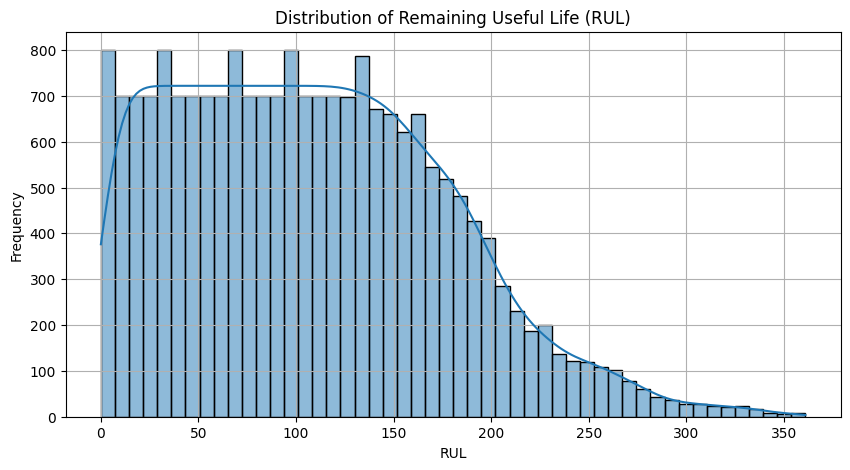

In [22]:
# ========== RUL DISTRIBUTION ==========
plt.figure(figsize=(10, 5))
sns.histplot(train_df['RUL'], bins=50, kde=True)
plt.title('Distribution of Remaining Useful Life (RUL)')
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

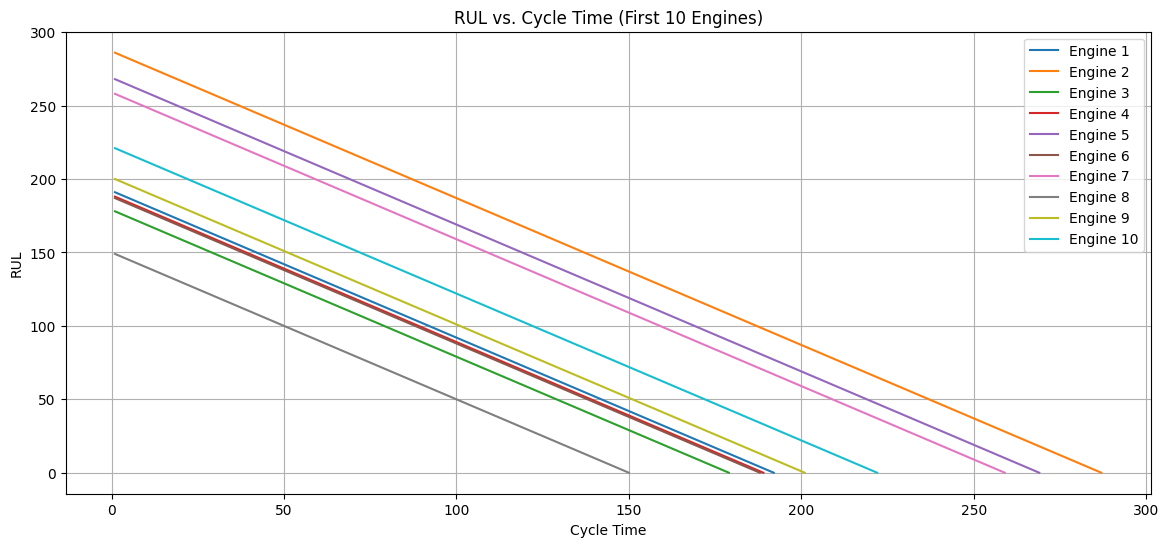

In [23]:
# ========== CYCLE TIME PER ENGINE ==========
plt.figure(figsize=(14, 6))
for eng_id in train_df["engine"].unique()[:10]:  # limit to first 10 engines for clarity
    subset = train_df[train_df["engine"] == eng_id]
    plt.plot(subset["cycle_time"], subset["RUL"], label=f'Engine {eng_id}')
plt.title("RUL vs. Cycle Time (First 10 Engines)")
plt.xlabel("Cycle Time")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()


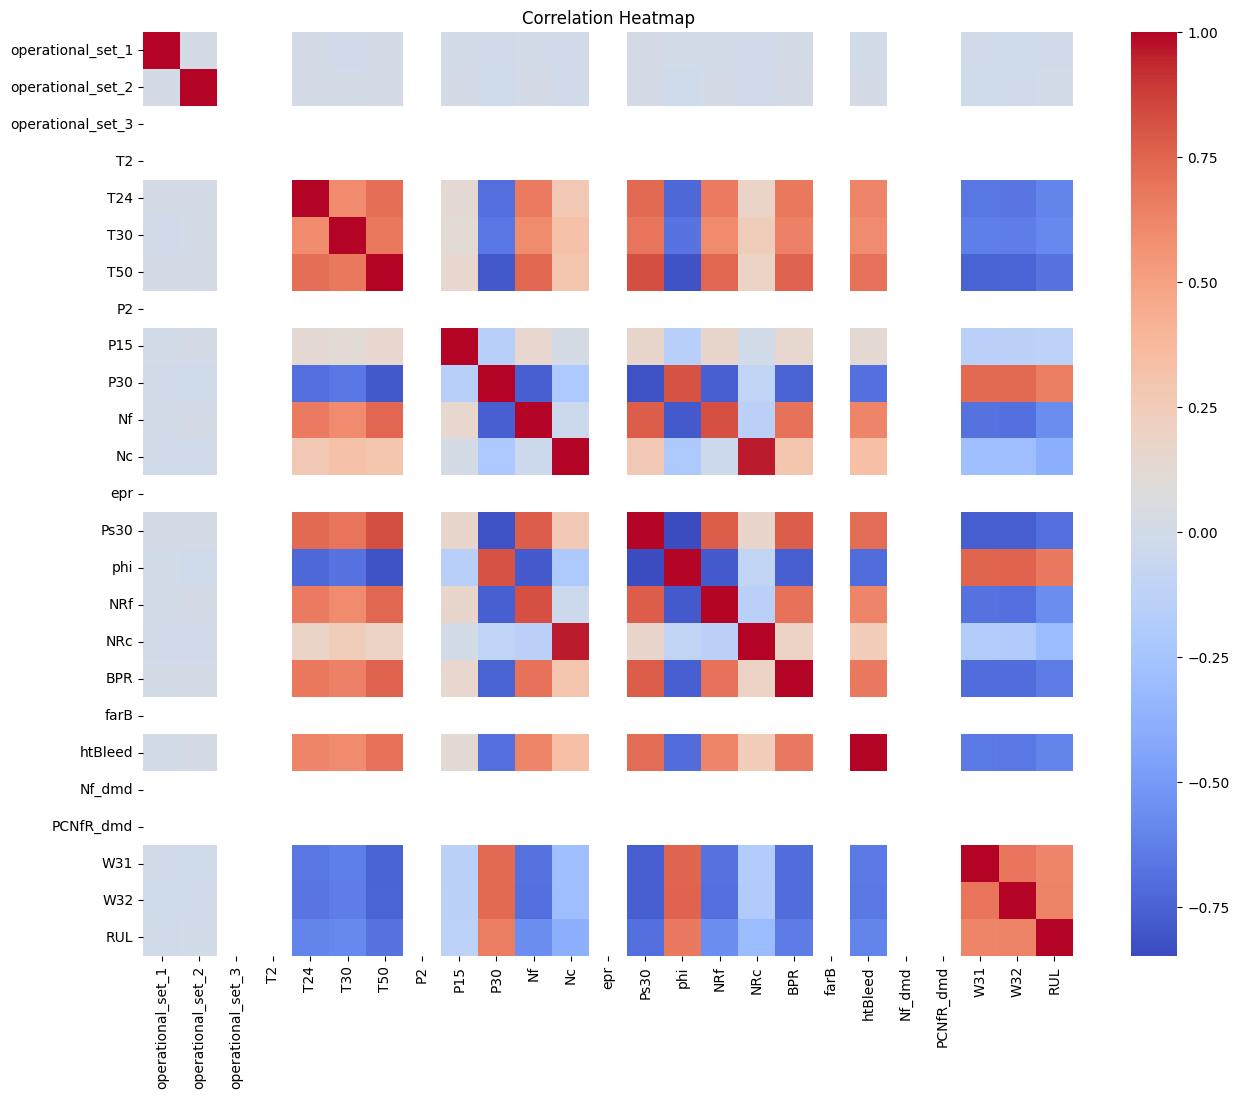

In [25]:
# ========== CORRELATION HEATMAP ==========
# Drop non-numeric or identifier columns
corr_df = train_df.drop(["engine", "cycle_time"], axis=1)
corr_matrix = corr_df.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

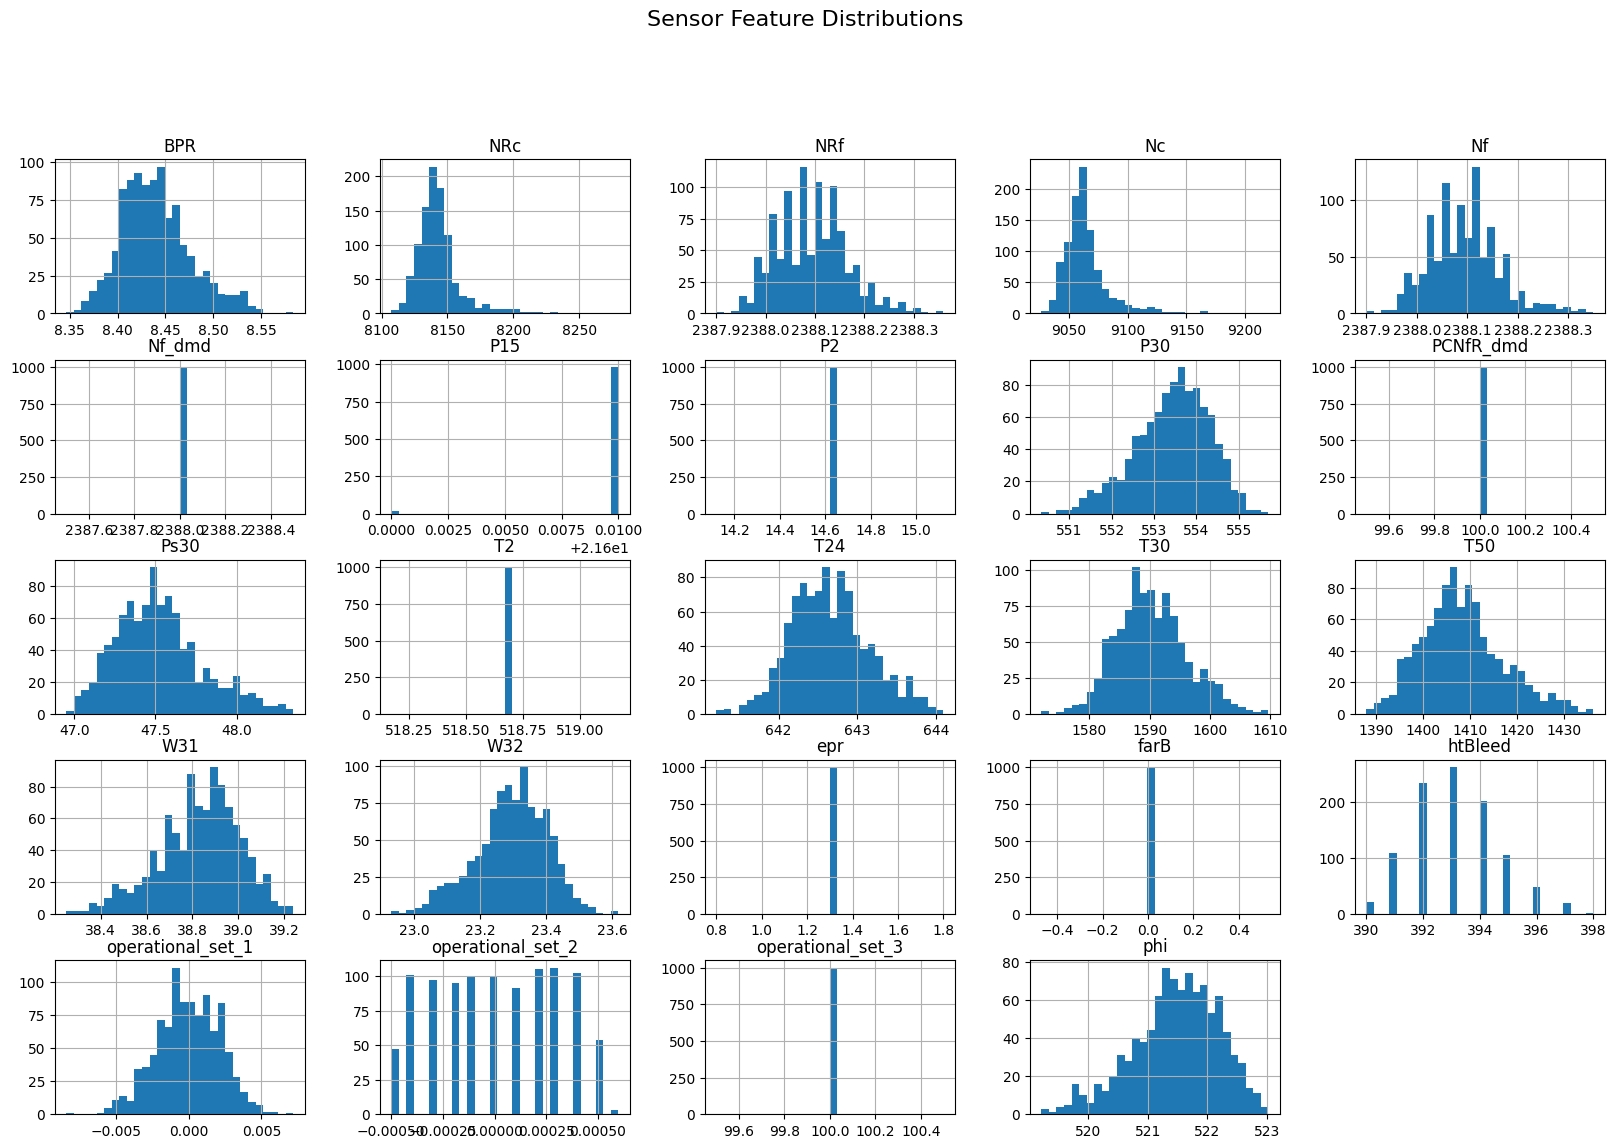

In [26]:
# ========== SENSOR DISTRIBUTIONS ==========
sensor_cols = train_df.columns.difference(["engine", "cycle_time", "RUL"])
sampled_data = train_df[sensor_cols].sample(n=1000, random_state=42)

sampled_data.hist(bins=30, figsize=(20, 15), layout=(6, 5))
plt.suptitle("Sensor Feature Distributions", fontsize=16)
plt.show()

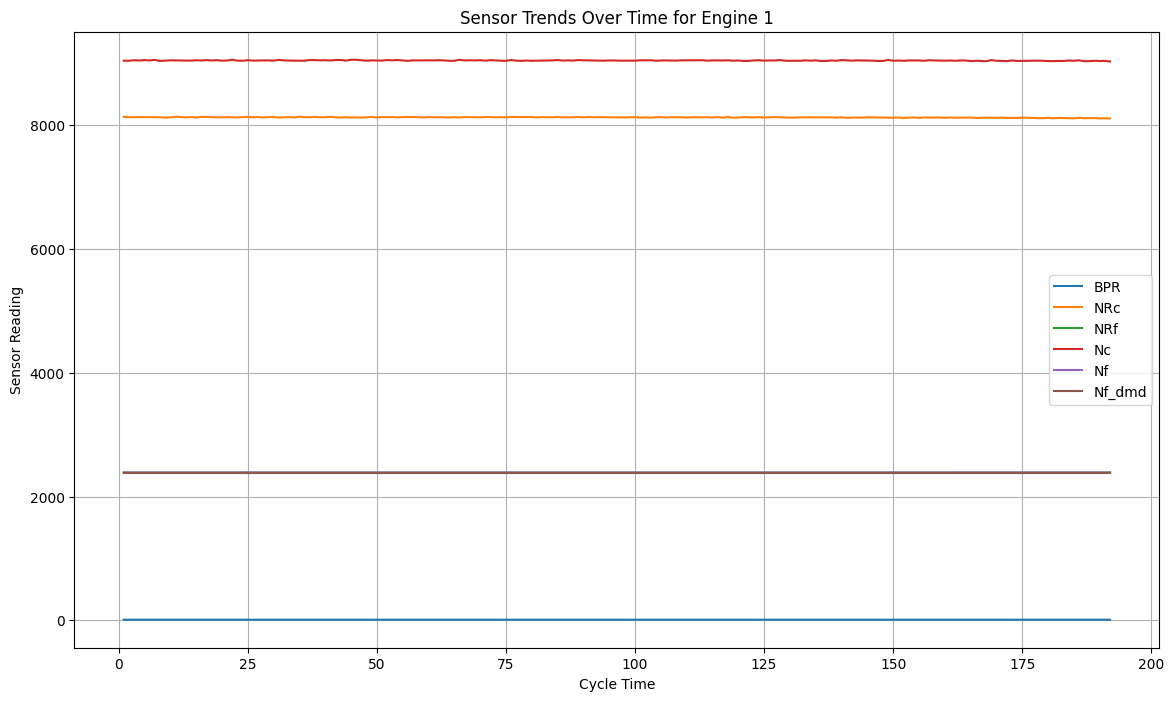

In [27]:
# ========== SENSOR TREND FOR ONE ENGINE ==========
engine_id = 1
sample_engine = train_df[train_df["engine"] == engine_id]

plt.figure(figsize=(14, 8))
for col in sensor_cols[:6]:  # Plotting first 6 sensor features
    plt.plot(sample_engine["cycle_time"], sample_engine[col], label=col)
plt.title(f"Sensor Trends Over Time for Engine {engine_id}")
plt.xlabel("Cycle Time")
plt.ylabel("Sensor Reading")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Drop non-informative or identifier columns
drop_cols = ["engine", "cycle_time"]  # Keep RUL as target
features_df = train_df.drop(columns=drop_cols)

# 2. Identify constant features
constant_cols = [col for col in features_df.columns if features_df[col].nunique() <= 1]
print("Constant columns to drop:", constant_cols)
features_df.drop(columns=constant_cols, inplace=True)

# 3. Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(features_df.drop(columns=["RUL"]))
y = features_df["RUL"].values

# 4. Train-Test Split (stratify not needed since RUL is continuous)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Constant columns to drop: ['operational_set_3', 'T2', 'P2', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd']
✅ Train shape: (16504, 17), Test shape: (4127, 17)


Constant columns to drop: ['operational_set_3', 'T2', 'P2', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd']
✅ Train shape: (16504, 17), Test shape: (4127, 17)
Training baseline Linear Regression, Random Forest, and Gradient Boosting models...

Baseline Linear Regression Performance:
  MAE: 34.05
  RMSE: 44.34
  R²: 0.570

Baseline Random Forest Performance:
  MAE: 29.63
  RMSE: 41.46
  R²: 0.624

Baseline Gradient Boosting Performance:
  MAE: 29.88
  RMSE: 41.37
  R²: 0.625


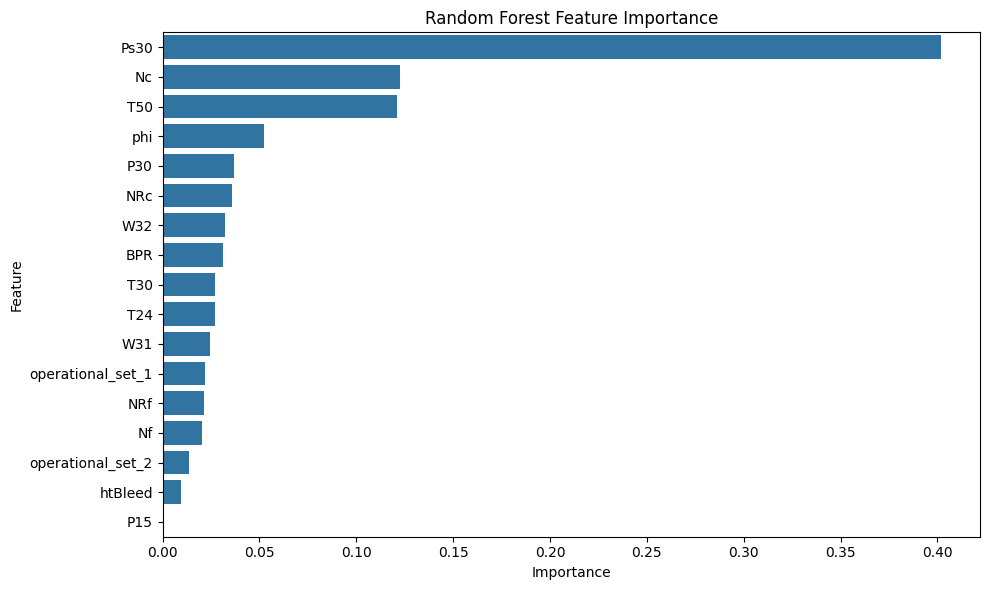

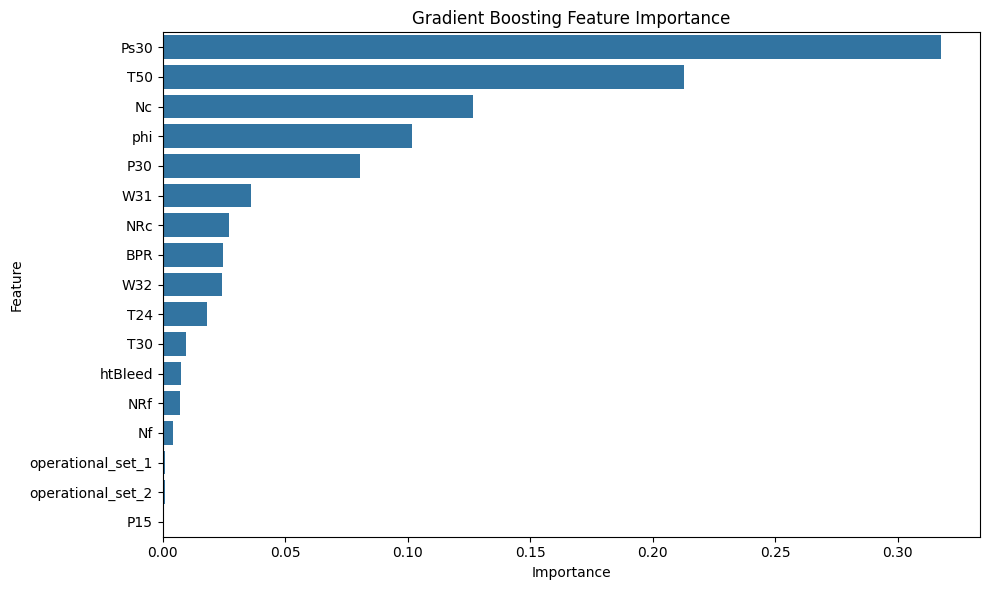


Starting Random Forest hyperparameter tuning...
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_

Best RF params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}

Starting Gradient Boosting hyperparameter tuning...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best GB params: {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.1}

Tuned Random Forest Performance:
  MAE: 29.25
  RMSE: 40.93
  R²: 0.633

Tuned Gradient Boosting Performance:
  MAE: 29.55
  RMSE: 41.39
  R²: 0.625


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Your preprocessing steps ===

# 1. Drop non-informative or identifier columns
drop_cols = ["engine", "cycle_time"]  # Keep RUL as target
features_df = train_df.drop(columns=drop_cols)

# 2. Identify constant features
constant_cols = [col for col in features_df.columns if features_df[col].nunique() <= 1]
print("Constant columns to drop:", constant_cols)
features_df.drop(columns=constant_cols, inplace=True)

# 3. Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(features_df.drop(columns=["RUL"]))
y = features_df["RUL"].values

# 4. Train-Test Split (stratify not needed since RUL is continuous)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# === Convert X_train and X_test back to DataFrames for feature importance plotting ===
feature_names = features_df.drop(columns=["RUL"]).columns
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# === Functions ===

def plot_feature_importance(model, X_train, title):
    importances = model.feature_importances_
    feature_names = X_train.columns
    fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    fi_df = fi_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x='Importance', y='Feature', data=fi_df)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return mae, rmse, r2

# === Train baseline models ===
print("Training baseline Linear Regression, Random Forest, and Gradient Boosting models...")

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Random Forest
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)

# === Evaluate baseline models ===
lr_mae, lr_rmse, lr_r2 = evaluate_model(lr, X_test, y_test)
rf_mae, rf_rmse, rf_r2 = evaluate_model(rf, X_test, y_test)
gb_mae, gb_rmse, gb_r2 = evaluate_model(gb, X_test, y_test)

print(f"\nBaseline Linear Regression Performance:\n  MAE: {lr_mae:.2f}\n  RMSE: {lr_rmse:.2f}\n  R²: {lr_r2:.3f}")
print(f"\nBaseline Random Forest Performance:\n  MAE: {rf_mae:.2f}\n  RMSE: {rf_rmse:.2f}\n  R²: {rf_r2:.3f}")
print(f"\nBaseline Gradient Boosting Performance:\n  MAE: {gb_mae:.2f}\n  RMSE: {gb_rmse:.2f}\n  R²: {gb_r2:.3f}")

# === Plot feature importances for tree-based models ===
plot_feature_importance(rf, X_train_df, "Random Forest Feature Importance")
plot_feature_importance(gb, X_train_df, "Gradient Boosting Feature Importance")

# === Hyperparameter grids ===
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.7, 1.0]
}

# === Setup RandomizedSearchCV for RF ===
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=rf_param_grid,
    n_iter=30,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

# === Setup RandomizedSearchCV for GB ===
gb_random_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=gb_param_grid,
    n_iter=30,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

# === Run hyperparameter tuning ===
print("\nStarting Random Forest hyperparameter tuning...")
rf_random_search.fit(X_train, y_train)
print("Best RF params:", rf_random_search.best_params_)

print("\nStarting Gradient Boosting hyperparameter tuning...")
gb_random_search.fit(X_train, y_train)
print("Best GB params:", gb_random_search.best_params_)

# === Evaluate tuned models ===
rf_best = rf_random_search.best_estimator_
gb_best = gb_random_search.best_estimator_

rf_mae, rf_rmse, rf_r2 = evaluate_model(rf_best, X_test, y_test)
gb_mae, gb_rmse, gb_r2 = evaluate_model(gb_best, X_test, y_test)

print(f"\nTuned Random Forest Performance:\n  MAE: {rf_mae:.2f}\n  RMSE: {rf_rmse:.2f}\n  R²: {rf_r2:.3f}")
print(f"\nTuned Gradient Boosting Performance:\n  MAE: {gb_mae:.2f}\n  RMSE: {gb_rmse:.2f}\n  R²: {gb_r2:.3f}")
